In [1]:
# requires browser refresh after installation
!pip install ipympl -q


In [2]:
%matplotlib ipympl

In [3]:
import intake
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from dask.distributed import Client
import matplotlib.pyplot as plt

The spatial and temporal distribution of AR events as a function of AR scale category relies on vertically integrated vapor transport (IVT), which is calculated as 

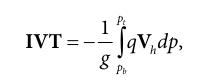

where 

- q is the specific humidity
- Vh is the horizontal wind vector
- g is the acceleration due to gravity
- pb is 1,000 hPa
- and pt is 200 hPa

The IVT is calculated using atmospheric data from the MERRA reanalysis at 0.5° × 0.625° horizontal resolution (Rienecker et al. 2011). Vertical levels used to calculate IVT are every 25 hPa from 1,000 to 700 hPa and every 50 hPa from 700 to 200 hPa.

In [4]:
# List the data available in the Intake Catalog
catalog = intake.open_esm_datastore(
    'https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json'
)
catalog

,unique
variable,53
long_name,51
component,4
experiment,2
forcing_variant,2
frequency,3
vertical_levels,3
spatial_domain,3
units,20
start_time,4


In [5]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/castronova/proxy/8787/status,
Dashboard: /user/castronova/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 15.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35221,Workers: 4
Dashboard: /user/castronova/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 15.00 GiB
Comm: tcp://127.0.0.1:43681,Total threads: 1
Dashboard: /user/castronova/proxy/33019/status,Memory: 3.75 GiB
Nanny: tcp://127.0.0.1:41877,


In [6]:
catalog_subset = catalog.search(variable='Q', frequency='daily')
catalog_subset.df

,variable,long_name,component,experiment,forcing_variant,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,Q,specific humidity,atm,historical,cmip6,daily,32.0,global,kg/kg,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
1,Q,specific humidity,atm,historical,smbb,daily,32.0,global,kg/kg,1850-01-01 12:00:00,2015-01-01 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
2,Q,specific humidity,atm,ssp370,cmip6,daily,32.0,global,kg/kg,2015-01-01 12:00:00,2100-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-ssp370-...


In [7]:
catalog_subset = catalog.search(variable=['U', 'V'], frequency='daily')
catalog_subset.df

,variable,long_name,component,experiment,forcing_variant,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,U,zonal wind,atm,historical,cmip6,daily,32.0,global,m/s,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
1,V,meridional wind,atm,historical,cmip6,daily,32.0,global,m/s,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
2,U,zonal wind,atm,historical,smbb,daily,32.0,global,m/s,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
3,V,meridional wind,atm,historical,smbb,daily,32.0,global,m/s,1850-01-01 12:00:00,2014-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-histori...
4,U,zonal wind,atm,ssp370,cmip6,daily,32.0,global,m/s,2015-01-01 12:00:00,2100-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-ssp370-...
5,V,meridional wind,atm,ssp370,cmip6,daily,32.0,global,m/s,2015-01-01 12:00:00,2100-12-31 12:00:00,s3://ncar-cesm2-lens/atm/daily/cesm2LE-ssp370-...


## Compute AR Categories

Load data from 1980 - 1989

In [4]:
ds = xr.open_dataset('b.e21.BHISTsmbb.f09_g17.LE2-1111.006.cam.h2.IVT.1980010100-1989123100.nc')

Select a single grid cell that covers Bodega Bay, CA (38.3332° N, 123.0481° W)

In [5]:
lat = 38.
lon = -123.125 + 360 
ds_ivt = ds.sel(lat=lat, lon=lon, method='nearest').IVT

Plot the IVT data for this cell 

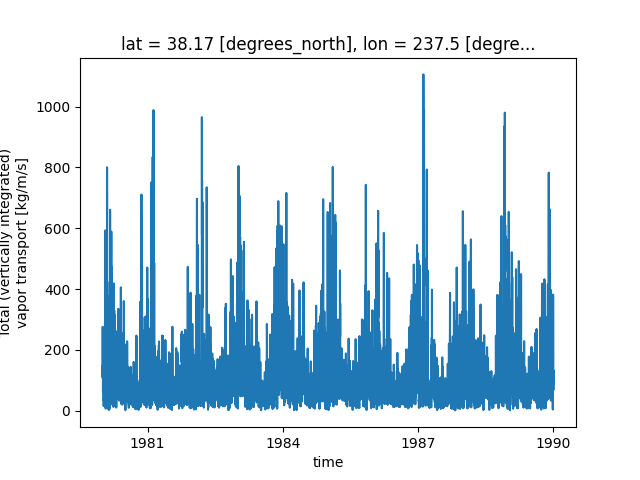

In [6]:
fig, ax = plt.subplots()
ds_ivt.plot();

Identify the 1986 AR event.

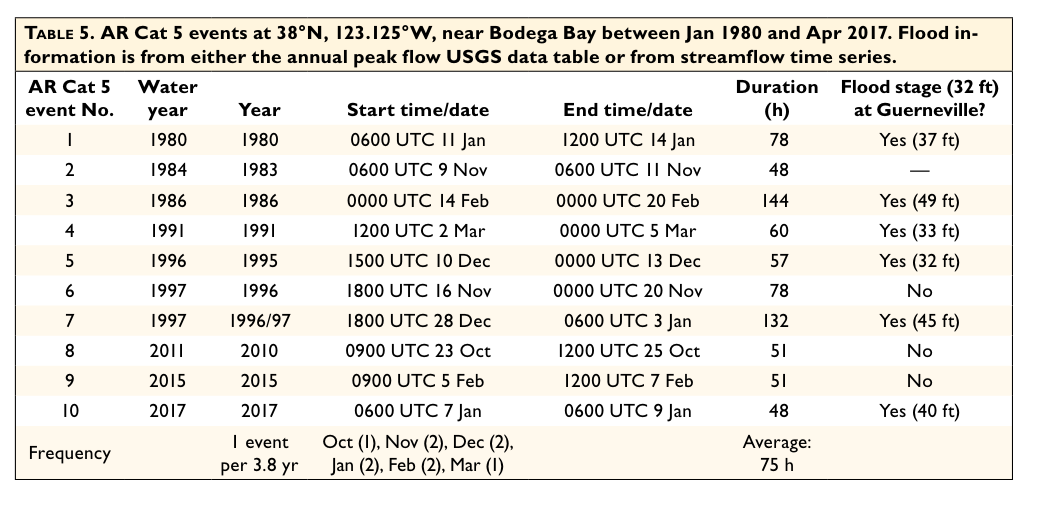


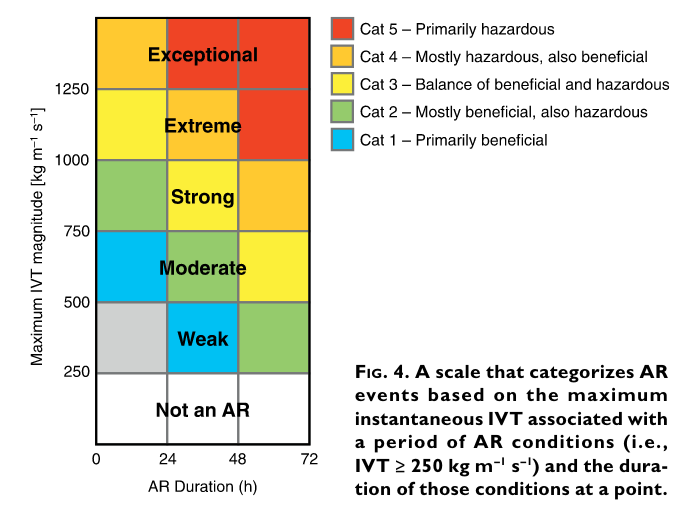

Subset the data temporally to capture a single event.

In [201]:
st = "1980-01-01"
et = "1989-12-31"

ds_subset = ds_ivt.sel(time=slice(st, et))

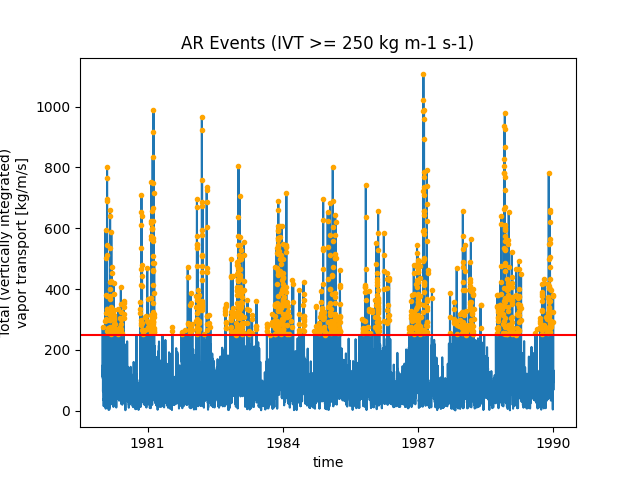

In [202]:
fig, ax = plt.subplots()
ds_subset.plot()
ds_subset.where((ds_subset >= thr_ar_cond)).plot(linestyle='', marker='.', color='orange')
ax.axhline(y=thr_ar_cond, color='red')
plt.title('AR Events (IVT >= 250 kg m-1 s-1)')
plt.show()

Test the AR events are located correctly


In [317]:
import importlib
importlib.reload(ARUtils)

<module 'ARUtils' from '/Users/castro/Documents/work/notebooks/data-processing/cesm2/ARUtils.py'>

In [318]:
# compute AR indices 
dat = ARUtils.create_ar_index_for_grid_cell(ds_subset.to_dataset())

In [319]:
for idx, d in dat.groupby(dat.AR_INDEX):
    if idx > 0:
        min_ivt = min(d.IVT.values)
        assert(min_ivt >= 250.0)
    

In [334]:
test_data = ds_subset.sel(time=slice('1980-01-01', '1980-02-28')).to_dataset()

# Initialize variables
event = 0
idx_start = 0
AR_THRESHOLD = 250.

ds_thr = xr.where((test_data.IVT >= AR_THRESHOLD), 1, 0)

flattened = np.insert(ds_thr, 0, 0, axis=0)
flattened = np.append(flattened, 0)

# Initialize variables
current_sequence = 0
ar_events = np.zeros(flattened.shape)
ar_duration = np.zeros(flattened.shape)
for idx in range(1, len(flattened)):
    # we hit a value of 1
    if flattened[idx] == 1:
        if flattened[idx - 1] == 0:
            # this is the first value in the set
            idx_start = idx
            event += 1
        current_sequence += 1
        ar_events[idx] = event

        print(f'{idx}: {current_sequence}, Event={event}, IVT={test_data.IVT.isel(time=idx-1).values}')

    # we hit a value of 0
    else:
        if current_sequence > 0:
            ar_duration[idx_start:idx] = current_sequence
        current_sequence = 0

ar_duration = ar_duration[1:-1]
ar_events = ar_events[1:-1]

test_data['AR_INDEX'] = (('time'), ar_events)
test_data['AR_DURATION'] = (('time'), ar_duration)

6: 1, Event=1, IVT=275.8721008300781
96: 1, Event=2, IVT=293.58587646484375
97: 2, Event=2, IVT=593.3134765625
98: 3, Event=2, IVT=322.05560302734375
114: 1, Event=3, IVT=301.299072265625
115: 2, Event=3, IVT=380.4876403808594
116: 3, Event=3, IVT=500.7789001464844
144: 1, Event=4, IVT=333.46380615234375
145: 2, Event=4, IVT=545.3287963867188
146: 3, Event=4, IVT=697.829833984375
147: 4, Event=4, IVT=800.393310546875
148: 5, Event=4, IVT=765.4512939453125
149: 6, Event=4, IVT=688.5072021484375
150: 7, Event=4, IVT=513.6070556640625
151: 8, Event=4, IVT=333.0722351074219
159: 1, Event=5, IVT=262.4682312011719
160: 2, Event=5, IVT=378.1950988769531
161: 3, Event=5, IVT=299.02825927734375
162: 4, Event=5, IVT=264.5582275390625
163: 5, Event=5, IVT=273.0200500488281
233: 1, Event=6, IVT=299.6871337890625
234: 2, Event=6, IVT=399.92852783203125
235: 3, Event=6, IVT=424.05865478515625
236: 4, Event=6, IVT=323.9098205566406


In [335]:
for idx in range(0, len(ar_events)):
    val = ar_events[idx]
    if val > 0:
        print(f'{idx}: Event={val}, IVT={test_data.isel(time=int(idx)).IVT.values}')
    

5: Event=1.0, IVT=275.8721008300781
95: Event=2.0, IVT=293.58587646484375
96: Event=2.0, IVT=593.3134765625
97: Event=2.0, IVT=322.05560302734375
113: Event=3.0, IVT=301.299072265625
114: Event=3.0, IVT=380.4876403808594
115: Event=3.0, IVT=500.7789001464844
143: Event=4.0, IVT=333.46380615234375
144: Event=4.0, IVT=545.3287963867188
145: Event=4.0, IVT=697.829833984375
146: Event=4.0, IVT=800.393310546875
147: Event=4.0, IVT=765.4512939453125
148: Event=4.0, IVT=688.5072021484375
149: Event=4.0, IVT=513.6070556640625
150: Event=4.0, IVT=333.0722351074219
158: Event=5.0, IVT=262.4682312011719
159: Event=5.0, IVT=378.1950988769531
160: Event=5.0, IVT=299.02825927734375
161: Event=5.0, IVT=264.5582275390625
162: Event=5.0, IVT=273.0200500488281
232: Event=6.0, IVT=299.6871337890625
233: Event=6.0, IVT=399.92852783203125
234: Event=6.0, IVT=424.05865478515625
235: Event=6.0, IVT=323.9098205566406


In [337]:
for idx, d in test_data.groupby(test_data.AR_INDEX):
    if idx > 0:
        min_ivt = min(d.IVT.values)
        assert(min_ivt >= 250.0)

In [348]:
test_data["AR_CATEGORY"] = (["time"], np.zeros(len(test_data.AR_INDEX)))
test_data

<xarray.Dataset> Size: 9kB
Dimensions:      (time: 236)
Coordinates:
    lat          float64 8B 38.17
    lon          float64 8B 237.5
  * time         (time) object 2kB 1980-01-01 00:00:00 ... 1980-02-28 18:00:00
Data variables:
    IVT          (time) float32 944B 130.7 133.5 154.3 ... 399.9 424.1 323.9
    AR_INDEX     (time) float64 2kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 6.0 6.0 6.0 6.0
    AR_DURATION  (time) float64 2kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 4.0 4.0 4.0 4.0
    AR_CATEGORY  (time) float64 2kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [349]:
# Global params
AR_THRESHOLD = 250  # minimum threshold for AR detection (250 kg/m/s)

# Initialize AR Category lookup table
# AR[IVT/10, Duration (hours)]
AR = np.zeros((200, 144)) + 5
# cat 4
AR[125:150, :24] = 4
AR[100:125, 24:48] = 4
AR[75:100, 48:72] = 4
AR[50:75, 72:96] = 4
AR[25:50, 96:120] = 4
# cat 3
AR[100:125, :24] = 3
AR[75:100, 24:48] = 3
AR[50:75, 48:72] = 3
AR[25:50, 72:96] = 3
# cat 2
AR[75:100, :24] = 2
AR[50:75, 24:48] = 2
AR[25:50, 48:72] = 2
# cat 1
AR[50:75, :24] = 1
AR[25:50, 24:48] = 1
# cat 0
AR[:25, :] = 0
AR[25:50, :24] = 0

In [350]:
# compute AR Category by combining max_ivt and AR duration.
for ar_id, d in test_data.groupby(test_data["AR_INDEX"]):
    
    if ar_id > 0:
        
        max_ivt = int(round(d.IVT.max().values / 10, 0))
        duration = (int(d.AR_DURATION.max().values) * 6) 
        print(f'AR_ID: {ar_id}, MAX_IVT: {max_ivt}, DURATION: {duration}, CAT: {AR[max_ivt, duration]}')
        
        at = AR[max_ivt, duration]
        
        test_data["AR_CATEGORY"] = test_data["AR_CATEGORY"].where(test_data["AR_INDEX"] != ar_id, other=cat)


AR_ID: 1.0, MAX_IVT: 28, DURATION: 6, CAT: 0.0
AR_ID: 2.0, MAX_IVT: 59, DURATION: 18, CAT: 1.0
AR_ID: 3.0, MAX_IVT: 50, DURATION: 18, CAT: 1.0
AR_ID: 4.0, MAX_IVT: 80, DURATION: 48, CAT: 4.0
AR_ID: 5.0, MAX_IVT: 38, DURATION: 30, CAT: 1.0
AR_ID: 6.0, MAX_IVT: 42, DURATION: 24, CAT: 1.0


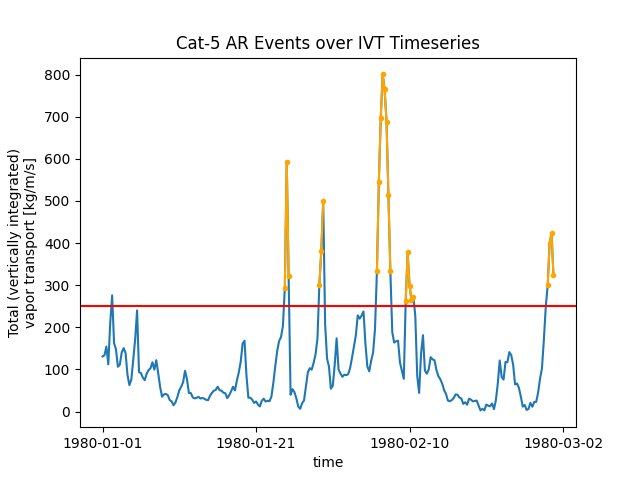

In [375]:
fig, ax = plt.subplots()

test_data.IVT.plot()


for idx, dd in test_data.groupby(test_data.AR_INDEX):
    if idx > 0:
        vals = dd.IVT.values
        if len(vals) > 1:
            dd.IVT.plot(linestyle='-', marker='.', color='orange')

ax.axhline(y=thr_ar_cond, color='red')


plt.title('Cat-5 AR Events over IVT Timeseries')
plt.show()

In [ ]:
test_data = ds_subset.sel(time=slice('1980-01-01', '1980-02-28')).to_dataset()

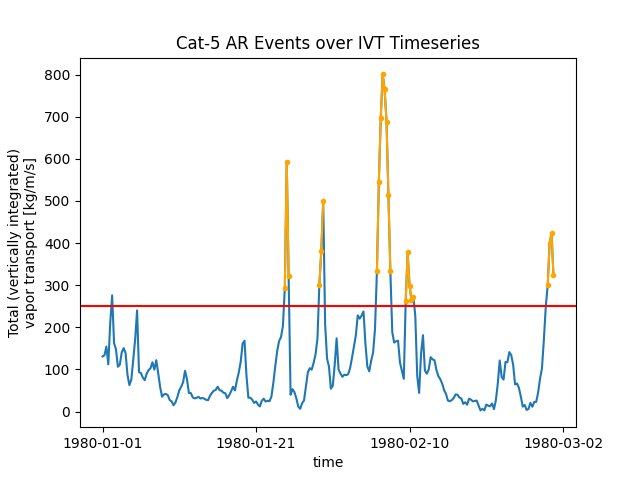

In [377]:
import ARUtils

# compute AR indices 
# dat = ARUtils.create_ar_index_for_grid_cell(ds_subset.to_dataset())
dat = ARUtils.create_ar_index_for_grid_cell(test_data)

# compute AR categories
dat = ARUtils.compute_ar_categories(dat)



fig, ax = plt.subplots()
test_data.IVT.plot()
for idx, dd in test_data.groupby(test_data.AR_INDEX):
    if idx > 0:
        vals = dd.IVT.values
        if len(vals) > 1:
            dd.IVT.plot(linestyle='-', marker='.', color='orange')

ax.axhline(y=thr_ar_cond, color='red')
plt.title('Cat-5 AR Events over IVT Timeseries')
plt.show()

Plot Cat-5 events along with IVT.

<xarray.Dataset> Size: 9kB
Dimensions:      (time: 254)
Coordinates:
    lat          float64 8B 38.17
    lon          float64 8B 237.5
  * time         (time) object 2kB 1981-02-15 12:00:00 ... 1988-12-04 06:00:00
Data variables:
    IVT          (time) float32 1kB 293.4 315.6 414.0 ... 275.1 182.2 211.4
    AR_INDEX     (time) float64 2kB 45.0 45.0 45.0 45.0 ... 280.0 280.0 280.0
    AR_DURATION  (time) float64 2kB 12.0 12.0 12.0 12.0 ... 23.0 23.0 0.0 0.0
    AR_CATEGORY  (time) float64 2kB 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0

In [209]:
dat.where(dat.AR_CATEGORY == 5, drop=True)

<xarray.Dataset> Size: 9kB
Dimensions:      (time: 254)
Coordinates:
    lat          float64 8B 38.17
    lon          float64 8B 237.5
  * time         (time) object 2kB 1981-02-15 12:00:00 ... 1988-12-04 06:00:00
Data variables:
    IVT          (time) float32 1kB 293.4 315.6 414.0 ... 275.1 182.2 211.4
    AR_INDEX     (time) float64 2kB 45.0 45.0 45.0 45.0 ... 280.0 280.0 280.0
    AR_DURATION  (time) float64 2kB 12.0 12.0 12.0 12.0 ... 23.0 23.0 0.0 0.0
    AR_CATEGORY  (time) float64 2kB 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0

In [215]:

#.groupby(dat.AR_INDEX)

DatasetGroupBy, grouped over 'AR_INDEX'
7 groups with labels 45.0, 66.0, 88.0, ..., 234.0, 280.0.

In [380]:
import ARUtils

# compute AR indices 
dat = ARUtils.create_ar_index_for_grid_cell(ds_subset.to_dataset())

# compute AR categories
dat = ARUtils.compute_ar_categories(dat)

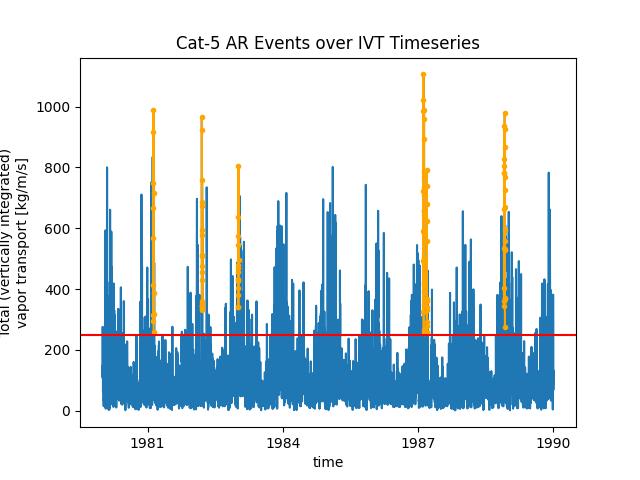

In [381]:
fig, ax = plt.subplots()

ds_subset.plot()

#ds_subset.where((ds_subset >= thr_ar_cond)).plot(linestyle='', marker='.', color='orange')
ds_cat5 = dat.where(dat.AR_CATEGORY == 5, drop=True) 
for idx, ds5 in ds_cat5.groupby(ds_cat5.AR_INDEX):
    ds5.IVT.plot(linestyle='-', marker='.', color='orange')

ax.axhline(y=thr_ar_cond, color='red')


plt.title('Cat-5 AR Events over IVT Timeseries')
plt.show()

In [226]:
ds_cat5.where(ds_cat5.AR_INDEX == 280, drop=True)

<xarray.Dataset> Size: 916B
Dimensions:      (time: 25)
Coordinates:
    lat          float64 8B 38.17
    lon          float64 8B 237.5
  * time         (time) object 200B 1988-11-28 06:00:00 ... 1988-12-04 06:00:00
Data variables:
    IVT          (time) float32 100B 533.6 826.2 781.9 ... 275.1 182.2 211.4
    AR_INDEX     (time) float64 200B 280.0 280.0 280.0 ... 280.0 280.0 280.0
    AR_DURATION  (time) float64 200B 23.0 23.0 23.0 23.0 ... 23.0 23.0 0.0 0.0
    AR_CATEGORY  (time) float64 200B 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0

In [227]:
ds_cat5.where(ds_cat5.AR_INDEX == 280, drop=True).IVT

<xarray.DataArray 'IVT' (time: 25)> Size: 100B
array([533.57666, 826.24646, 781.9468 , 780.5699 , 935.4131 , 805.4056 ,
       663.944  , 402.92874, 359.64716, 345.83093, 367.76218, 532.01605,
       926.37805, 868.8011 , 724.80133, 768.912  , 671.5044 , 559.6384 ,
       528.6972 , 593.84143, 980.4076 , 369.22684, 275.12524, 182.15535,
       211.40012], dtype=float32)
Coordinates:
    lat      float64 8B 38.17
    lon      float64 8B 237.5
  * time     (time) object 200B 1988-11-28 06:00:00 ... 1988-12-04 06:00:00
Attributes:
    units:      kg/m/s
    long_name:  Total (vertically integrated) vapor transport